In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_chivi,
                       make_stan_log_density,
                       adagrad_optimize)
from experiments import (get_samples_and_log_weights, 
                         improve_with_psis,
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         plot_dist_to_opt_param,
                         check_approx_accuracy,
                         print_bounds)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

In [2]:
os.makedirs('../figures', exist_ok=True)
lims = dict(xlim=[-4,-1], ylim=[-.5,3.5])
mc_samples = 1000000  # number of Monte Carlo samples for estimating bounds and for PSIS

# Robust Linear Regression Example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{40}(\beta^\top x_n, 1)$$
and use Stan to compute (the gradient of) the model log density. 

For more details and discussion of this example, see:

[Practical posterior error bounds from variational objectives](https://arxiv.org/abs/1910.04102).
Jonathan H. Huggins,
Miko&#0322;aj Kasprzak,
Trevor Campbell,
Tamara Broderick.
In *Proc. of the 23rd International Conference on Artificial Intelligence and
Statistics* (AISTATS), Palermo, Italy. PMLR: Volume 108, 2020.

In [3]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  matrix[N, 2] x;   // predictor matrix
  vector[N] y;      // outcome vector
  real<lower=1> df; // degrees of freedom
}
parameters {
  vector[2] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(df, x * beta, 1);  // likelihood
}"""

In [4]:
regression_model = pystan.StanModel(model_code=regression_model_code, 
                                    model_name='regression_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL regression_model_da1de6f365ef6d14558a2a755c2fe849 NOW.


We generate 25 observations from the model with $\beta = (-2, 1)$.

In [5]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.75],[.75, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(40, N)
y = y_raw - np.mean(y_raw)

First, we generate ground truth samples using Stan's dynamic HMC implementation

In [6]:
data = dict(N=N, x=x, y=y, df=40)
fit = regression_model.sampling(data=data, iter=50000, thin=50, chains=10)

In [7]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
print('true mean =', true_mean)
print('true cov =', true_cov)

true mean = [-2.52450734  1.51845591]
true cov = [[ 0.43276229 -0.43005391]
 [-0.43005391  0.4489401 ]]


In [8]:
fit

Inference for Stan model: regression_model_da1de6f365ef6d14558a2a755c2fe849.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]  -2.52  9.4e-3   0.66   -3.8  -2.97  -2.53  -2.08  -1.19   4913    1.0
beta[2]   1.52  9.5e-3   0.67   0.19   1.07   1.51   1.97   2.83   4985    1.0
lp__     -20.3    0.01   1.04 -23.08 -20.68 -19.97 -19.57 -19.31   5026    1.0

Samples were drawn using NUTS at Wed Feb 26 21:07:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

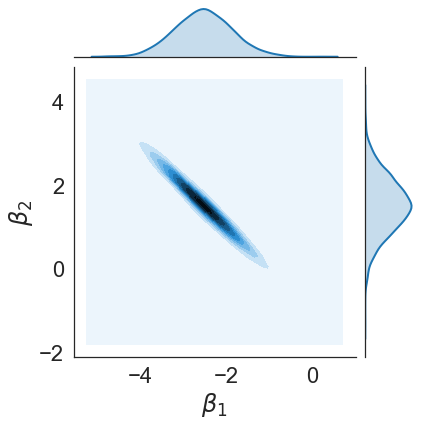

In [9]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, we compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence)

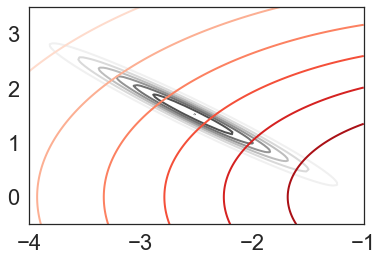

Average Loss = 24.216: 100%|██████████| 5000/5000 [00:20<00:00, 245.65it/s]


In [10]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(2, 40)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(2)
init_log_std = np.ones(2)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

We can plot the distance from the optimal parameter to visually verify convergence

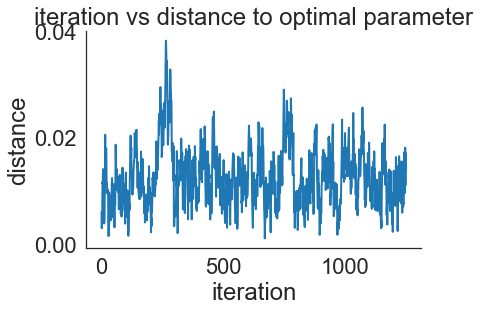

In [11]:
plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

Due to the strong posterior correlation, the variational approximation dramatically underestimates uncertainty

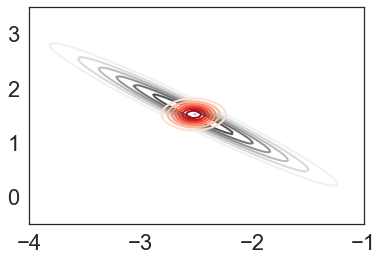

In [12]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi.pdf')

In [13]:
check_approx_accuracy(mf_t_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.52404451  1.52136443]
stdevs = [0.14346427 0.14578815]

mean error             = 0.00295
stdev error            = 0.734
||cov error||_2^{1/2}  = 0.922
||true cov||_2^{1/2}   = 0.933


We can check approximation quality using `viabel`. All bounds suggest the approximation is not good. 

In [14]:
_, log_weights = get_samples_and_log_weights(stan_log_density, mf_t_var_family, klvi_var_param, mc_samples)
elbo = np.mean(log_weights)
var_dist_cov = mf_t_var_family.mean_and_cov(klvi_var_param)[1]
moment_bound_fn = lambda p: mf_t_var_family.pth_moment(p, klvi_var_param)

klvi_results = all_bounds(log_weights, q_var=var_dist_cov, moment_bound_fn=moment_bound_fn)

print_bounds(klvi_results)

Bounds on...
  2-Wasserstein   4.35
  2-divergence    8.72
  mean error      4.35
  stdev error     4.35
  sqrt cov error  6.25
  cov error       39.1


In [15]:
klvi_psis_results, _, _ = improve_with_psis(stan_log_density, mf_t_var_family, klvi_var_param,
                                            mc_samples, true_mean, true_cov, verbose=True)

/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.92

mean   = [-2.56169589  1.55571733]
stdevs = [0.32622583 0.31209135]

mean error             = 0.0526
stdev error            = 0.488
||cov error||_2^{1/2}  = 0.824
||true cov||_2^{1/2}   = 0.933


## Mean-field variational inference with CHIVI

We can repeat the same procedure, but this time using CHIVI and a Student t mean-field variational family. 

In [16]:
mf_t_var_family = mean_field_t_variational_family(2, 40)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_var_param = klvi_var_param.copy()
init_var_param[2:] += 3

chivi_var_param, chivi_param_history, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = -18.898: 100%|██████████| 5000/5000 [01:42<00:00, 48.70it/s]


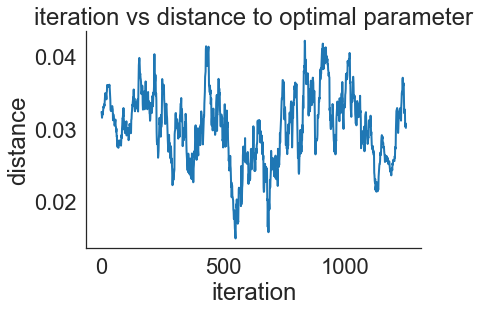

In [17]:
plot_dist_to_opt_param(chivi_param_history, chivi_var_param)

The variance is no longer so badly underestimated. But the variational approximation is still not very good, now greatly over-estimating the region with significant posterior mass. 

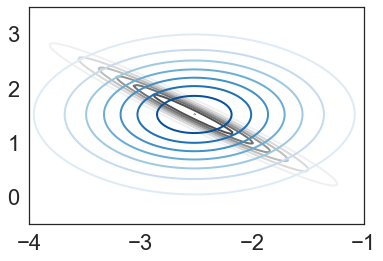

In [18]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, chivi_var_param, **lims,
                               cmap2='Blues', savepath='../figures/robust-regression-mf-chivi.pdf')

In [19]:
check_approx_accuracy(mf_t_var_family, chivi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.5182418   1.52051221]
stdevs = [0.71666519 0.73338569]

mean error             = 0.00659
stdev error            = 0.0864
||cov error||_2^{1/2}  = 0.718
||true cov||_2^{1/2}   = 0.933


The fact that approximation is still not good is reflected is the large bounds:

In [20]:
_, log_weights = get_samples_and_log_weights(stan_log_density, mf_t_var_family, chivi_var_param, mc_samples)
var_dist_cov = mf_t_var_family.mean_and_cov(chivi_var_param)[1]
moment_bound_fn = lambda p: mf_t_var_family.pth_moment(p, chivi_var_param)

chivi_results = all_bounds(log_weights, q_var=var_dist_cov, log_norm_bound=elbo, moment_bound_fn=moment_bound_fn)

print_bounds(chivi_results)

Bounds on...
  2-Wasserstein   8.37
  2-divergence    4.9
  mean error      8.37
  stdev error     8.37
  sqrt cov error  12.4
  cov error       153


In [21]:
chivi_psis_results, _, _ = improve_with_psis(stan_log_density, mf_t_var_family, chivi_var_param,
                                             mc_samples, true_mean, true_cov, verbose=True)

khat = 0.341

mean   = [-2.52373214  1.51998706]
stdevs = [0.65295089 0.6633713 ]

mean error             = 0.00172
stdev error            = 0.00826
||cov error||_2^{1/2}  = 0.124
||true cov||_2^{1/2}   = 0.933


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


## A non-mean-field approximation

Finally, we obtain a very good approximation by using a Student t variational family with a full-rank scaling matrix. 

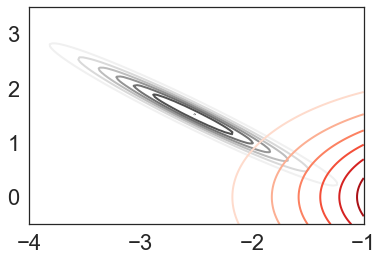

Average Loss = 22.656: 100%|██████████| 5000/5000 [00:34<00:00, 143.81it/s]


In [22]:
t_var_family = t_variational_family(2, 100)
full_klvi_objective_and_grad = black_box_klvi(t_var_family, stan_log_density, 100)

init_var_param = np.zeros(t_var_family.var_param_dim)
plot_approx_and_exact_contours(stan_log_density, t_var_family, init_var_param, **lims)
full_klvi_var_param, full_klvi_param_history, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)

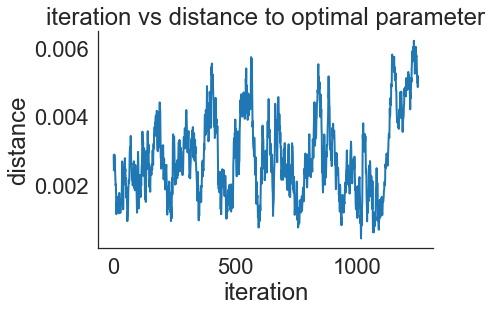

In [23]:
plot_dist_to_opt_param(full_klvi_param_history, full_klvi_var_param)

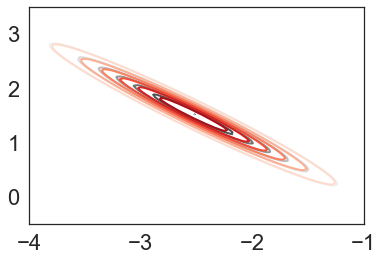

In [24]:
plot_approx_and_exact_contours(stan_log_density, t_var_family, full_klvi_var_param, **lims,
                               savepath='../figures/robust-regression-full-rank-klvi.pdf')

In [25]:
check_approx_accuracy(t_var_family, full_klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.52491437  1.52131867]
stdevs = [0.65700772 0.66745318]

mean error             = 0.00289
stdev error            = 0.00271
||cov error||_2^{1/2}  = 0.0689
||true cov||_2^{1/2}   = 0.933


Bounds computed using `viabel` -- and the 2-divergence bound in particular -- confirm that the approximation is accurate. 

In [26]:
_, log_weights = get_samples_and_log_weights(stan_log_density, t_var_family, full_klvi_var_param, mc_samples)
var_dist_cov = t_var_family.mean_and_cov(full_klvi_var_param)[1]
moment_bound_fn = lambda p: t_var_family.pth_moment(p, full_klvi_var_param)

full_klvi_results = all_bounds(log_weights, q_var=var_dist_cov, moment_bound_fn=moment_bound_fn)

print_bounds(full_klvi_results)

Bounds on...
  2-Wasserstein   0.385
  2-divergence    0.000592
  mean error      0.0456
  stdev error     0.385
  sqrt cov error  1.01
  cov error       1.01


In [27]:
full_klvi_psis_results, _, _ = improve_with_psis(stan_log_density, t_var_family, full_klvi_var_param,
                                                 mc_samples, true_mean, true_cov, verbose=True)

khat = -0.93

mean   = [-2.52488309  1.52143322]
stdevs = [0.6542771  0.66500373]

mean error             = 0.003
stdev error            = 0.00616
||cov error||_2^{1/2}  = 0.107
||true cov||_2^{1/2}   = 0.933


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)
